In [1]:
import sys
sys.path.append('../../PI_GP_regressor') 

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import gram_Matrix_jax,k_ff_jax, k_fu_jax, k_uf_jax, k_uu_jax
import numpy as np

In [2]:
# first we put the kernel parts into a list
kernel_list = [gram_Matrix_jax, k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
#then we define the parameters for the kernel
hyperparameters = ["l_x", "sigma_f","l_t", "alpha"]
#now we can define our model. The model needs the kernel list and the hyperparameters, aswell as the timedependence
model_heat_equation = PhysicsInformedGP_regressor(kernel_list,timedependence=True, params=hyperparameters,Dimensions=2)
model_heat_equation.set_name_kernel("Wave_equation")
#now we create the training data and a validation set
n_training_points = 20
noise = [1e-8,1e-8]
model_heat_equation.set_training_data("heat_data_paper.csv",n_training_points, noise,[5,12])

n_validation_points = 4000  #for calculating the MSE
model_heat_equation.set_validation_data(n_validation_points)
#model_heat_equation.plot_raw_data(True,False)

 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:917: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:929: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1006: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/heat_equation/../../PI_GP_regressor/main_class.py:1018: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


Now we can train the model. We can choose different methods for the training.   
  -CG: conjugate gradient --- fast but often not very accurate    
  -TNC: truncated Newton --- slower but more accurate     
  -L-BFGS-B: limited memory BFGS --- fast and accurate (not always for some reason)   

generally TNC is the best choice

In [3]:
#for the training we first need to define the initial parameters for the restarts
model_heat_equation.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial

n_restarts = 800; n_threads = 5
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-6}

model_heat_equation.train("TNC",n_restarts, n_threads,opt_params_dict)

  0%|          | 0/800 [00:00<?, ?it/s]

  4%|▍         | 30/800 [00:06<02:42,  4.73it/s]

KeyboardInterrupt: 

In [14]:
#old results
model_heat_equation.set_params([0.3540676 , 1.19323111, 1.00905818, 0.99905218]) # -4.077024459838867
model_heat_equation.set_params([0.36201261, 1.58119246, 1.08855962, 0.99929574]) # -5.320425033569336
#model_heat_equation.set_params([0.32882741, 1.53232479, 1.20066665, 1.00004202]) # -4.98200798034668

In [15]:
model_heat_equation.set_axis_labels("x","t")
model_heat_equation.jitter = 1e-6
n_test_points = 100
x_star, t_star = np.meshgrid(np.linspace(0, 1, n_test_points), np.linspace(0, 1, n_test_points))
X_star = np.hstack((x_star.reshape(-1, 1), t_star.reshape(-1, 1)))
model_heat_equation.predict_model(X_star)
model_heat_equation.error()
#print(model_heat_equation)
var = model_heat_equation.var_u
print(np.min(var))

-8.34465e-07


{'u': 0.0038706356300828837, 'f': 0.008520623400780629}

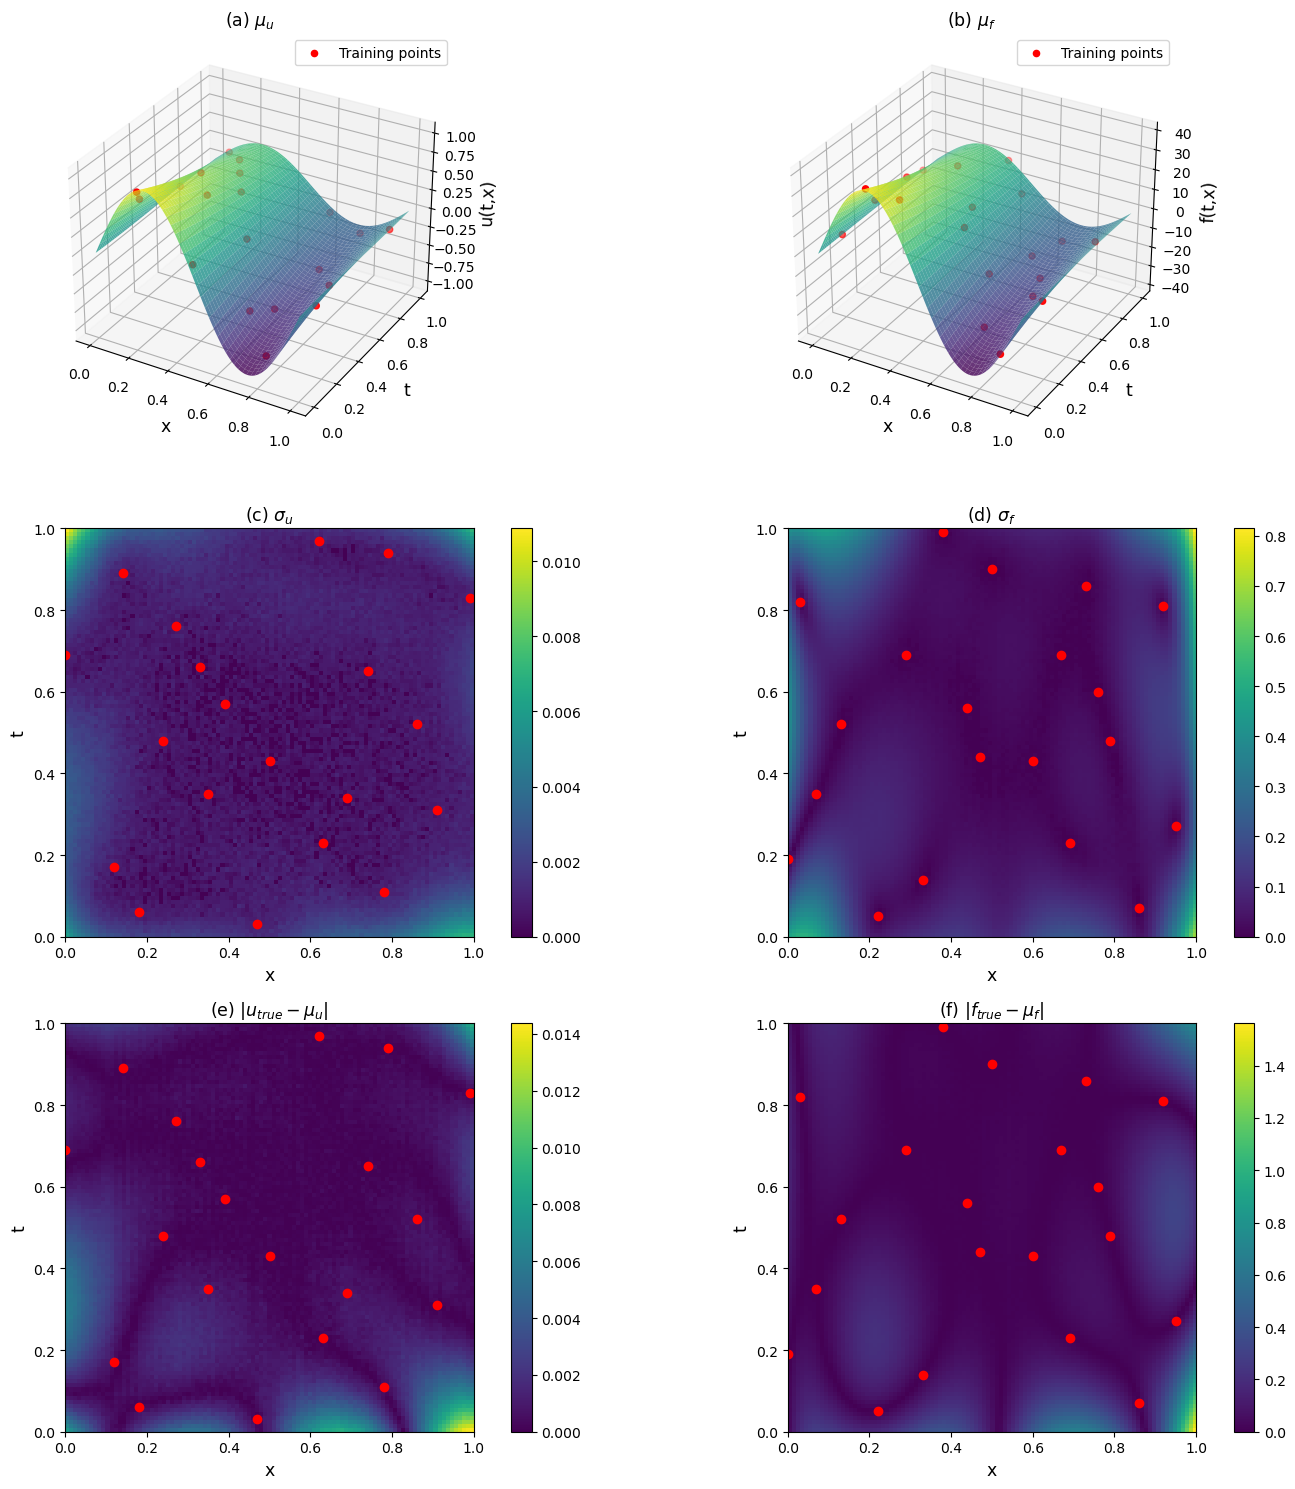

In [16]:
model_heat_equation.plot_merged_2d_plots(X_star,"merged_plots.png",figsize=(15,15))
model_heat_equation.rel_l2_error

We can now do the same with the GPy library with a non modified kernel(we just use the RBF kernel with ARD)

In [ ]:
model_heat_equation.use_GPy(X_star,"GPy_predictive_mean",False)

In [ ]:
model_heat_equation.plot_difference_GPy("difference GPy ", "GPy_difference.png")
model_heat_equation.plot_variance_GPy("predictive variance GPy ", "GPy_variance.png")

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

results = model_heat_equation.results_list

theta_list = np.array([thet.x for thet in results])
function_values = np.array([thet.fun for thet in results])
df_results = pd.DataFrame(theta_list, columns=["lx", "sigma_f","lt", "c"])
df_results["function_values"] = function_values
print(df_results.head())

df_results = df_results.sort_values(by=["c"])
loc_minimum = np.argmin(df_results["function_values"])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# plot 1
axs[0].scatter(np.array(df_results["c"]), (np.array(df_results["function_values"])), marker = "x")
axs[0].set_xlabel("$c$", fontsize=11)
axs[0].set_ylabel("$lmll(\\theta^*)$", fontsize=11)
axs[0].grid(True)
axs[0].legend()

# plot 2
df_results_below_zero = df_results[df_results["function_values"]<10]
axs[1].scatter(np.array(df_results_below_zero["c"]), np.array(df_results_below_zero["function_values"]), marker = "x")
axs[1].scatter(df_results.iloc[loc_minimum,3],(df_results.iloc[loc_minimum,4])  ,label = f"minimum with c = {df_results.iloc[loc_minimum, 3]:.5f} \ny = {df_results.iloc[loc_minimum, 4]:.5f}", color = "red")
axs[1].set_xlabel("$c$", fontsize=11)
axs[1].set_xlim(0.7,1.3)
axs[1].set_ylabel("$lmll(\\theta^*)$", fontsize=11)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


AttributeError: 'PhysicsInformedGP_regressor' object has no attribute 'results_list'

In [ ]:
#i want to look at the 10 best results
df_results = df_results.sort_values(by=["function_values"])
df_best_results = df_results.iloc[:15,:]
display(df_best_results)